<a href="https://colab.research.google.com/github/Murcha1990/ML_AI24/blob/main/Hometasks/Pro/AI_HW1_Regression_with_inference_pro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Домашнее задание №1 (pro)**

В этом домашнем задании вам будет необходимо:
*  обучить модель регрессии для предсказания стоимости автомобилей;
* реализовать веб-сервис для применения построенной модели на новых данных

> Оценка за домашку = $min(\text{ваш балл}, 11)$

**Мягкий дедлайн: 27 ноября 23:59**

**Жесткий дедлайн: 20 декабря 23:59 (конец модуля)**



**Примечание**

В каждой части оцениваются как код, **так и ответы на вопросы.** Вопросы подсвечены синим цветом.

Если нет одного и/или другого, то часть баллов за соответствующее задание снимается.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns
import re
import pickle
from itertools import combinations
from math import log
from ydata_profiling import ProfileReport
from scipy.stats import spearmanr
from phik.report import plot_correlation_matrix
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.linear_model import Lasso, Ridge, LinearRegression, ElasticNet
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV, cross_val_score

random.seed(42)
np.random.seed(42)

%matplotlib inline

### **Задание 0**
Для чего фиксируем сиды в домашках?

Фиксация random seed обеспечивает воспроизводимость экспериментов. Это нужно для сравнения результатов разных моделей и гиперпараметров. Без фиксированного seed результаты могут быть случайными, что затрудняет анализ и валидацию.

# **Часть 1 | EDA**


Первая часть состоит из классических шагов EDA:

- Базовый EDA и обработка признаков (1.7 балла)
- Визуализации признаков и их анализ (1.6 балл)

Всего можно набрать 3.3 основных балла и 0.25 бонусных.

В следующих частях, вы увидите бонусные задания. Бонусные задания выделены как **Дополнительное задание/Бонус**. Вы можете выполнять их, чтобы в случае ошибок в основных задачах всё равно набрать за работу максимум. Кроме того, дополнительные задания позволяют вам углубить знания.

Призываем активно использовать их!

## **Простейший EDA и обработка признаков (1.7 балла)**

In [2]:
df_train = pd.read_csv('https://raw.githubusercontent.com/Murcha1990/MLDS_ML_2022/main/Hometasks/HT1/cars_train.csv')
df_test = pd.read_csv('https://raw.githubusercontent.com/Murcha1990/MLDS_ML_2022/main/Hometasks/HT1/cars_test.csv')

print("Train data shape:", df_train.shape)
print("Test data shape: ", df_test.shape)

Train data shape: (6999, 13)
Test data shape:  (1000, 13)


### **Задание 1.(0.4 балла)**
Выполните операции, направленные на базовое исследование данных:

- [ ] Посмотрите, есть ли в датасете пропуски и дубликаты. Запишите/выведите названия колонок, для которых есть пропущенные значения (0.1 балла)
- [ ] Посмотрите, есть ли в данных явные дубликаты (0.05 балла)
- [ ] Постройте дашборд в одну строку, используя [ydata-profilling](https://github.com/ydataai/ydata-profiling)(0.15 балла)
- [ ] Опишите базовые выводы (какие — выберите сами), используя дашборд (0.2 балла)

In [3]:
missing_columns = df_train.columns[df_train.isnull().any()]
print("Названия колонок с пропущенными значениями:")
print(missing_columns)

Названия колонок с пропущенными значениями:
Index(['mileage', 'engine', 'max_power', 'torque', 'seats'], dtype='object')


In [4]:
duplicates_count = df_train.duplicated().sum()
print(f"Количество явных дубликатов: {duplicates_count}")

Количество явных дубликатов: 985


In [5]:
profile = ProfileReport(df_train, title="Dataframe Report", explorative=True)
profile.to_file("df_train_report.html")
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

km_driven сильно коррелирует с year \
selling_price сильно коррелирует с transmission и year \
В колонке name 27.5% значений - уникальные \
selling_price принимает значения от 29999 до 10000000 \
Самое популярное топливо - Dieselesel

### **Задание 2 (0.2 балла)**
Проанализируйте статистики датасета.

**Ваша задача:**
- [ ] Посчитайте основные статистики по числовым столбцам для трейна и теста
- [ ] Посчитайте основные статистики по категориальным столбцам для трейна и теста
- [ ] Сравните среднее и медиану внутри `train`, внутри `test` и между собой. О чём могут говорить результаты?

**Подсказка:**

Используте ``.describe()`` с нужным(и) аргументом(-ами).

In [6]:
df_train.describe()

year  selling_price     km_driven        seats
count  6999.000000   6.999000e+03  6.999000e+03  6797.000000
mean   2013.818403   6.395152e+05  6.958462e+04     5.419008
std       4.053095   8.089419e+05  5.772400e+04     0.965767
min    1983.000000   2.999900e+04  1.000000e+00     2.000000
25%    2011.000000   2.549990e+05  3.500000e+04     5.000000
50%    2015.000000   4.500000e+05  6.000000e+04     5.000000
75%    2017.000000   6.750000e+05  9.700000e+04     5.000000
max    2020.000000   1.000000e+07  2.360457e+06    14.000000

In [7]:
df_test.describe()

year  selling_price      km_driven       seats
count  1000.000000   1.000000e+03    1000.000000  981.000000
mean   2013.681000   6.179010e+05   71393.341000    5.410805
std       4.012149   7.585539e+05   48486.218662    0.919985
min    1995.000000   3.100000e+04    1303.000000    4.000000
25%    2011.000000   2.500000e+05   37000.000000    5.000000
50%    2014.000000   4.349990e+05   61500.000000    5.000000
75%    2017.000000   6.700000e+05  100000.000000    5.000000
max    2020.000000   6.000000e+06  375000.000000    9.000000

In [8]:
df_train.describe(include=object)

name    fuel seller_type transmission        owner  \
count                     6999    6999        6999         6999         6999   
unique                    1924       4           3            2            5   
top     Maruti Swift Dzire VDI  Diesel  Individual       Manual  First Owner   
freq                       116    3793        5826         6095         4587   

          mileage   engine max_power          torque  
count        6797     6797      6803            6796  
unique        386      120       316             419  
top     18.9 kmpl  1248 CC    74 bhp  190Nm@ 2000rpm  
freq          197      885       330             468

In [9]:
df_test.describe(include=object)

name    fuel seller_type transmission        owner  \
count                  1000    1000        1000         1000         1000   
unique                  621       4           3            2            5   
top     Maruti Alto 800 LXI  Diesel  Individual       Manual  First Owner   
freq                     15     534         837          877          623   

          mileage   engine max_power          torque  
count         981      981       981             981  
unique        237       88       182             226  
top     18.6 kmpl  1248 CC    74 bhp  200Nm@ 1750rpm  
freq           23      116        43              57

In [10]:
numeric_columns = df_train.select_dtypes(include=np.number).columns

mean_train = df_train[df_train.select_dtypes(include=np.number).columns].mean()
median_train = df_train[df_train.select_dtypes(include=np.number).columns].median()

mean_test = df_test[df_test.select_dtypes(include=np.number).columns].mean()
median_test = df_test[df_test.select_dtypes(include=np.number).columns].median()

In [11]:
pd.DataFrame({"Mean": mean_train, "Median": median_train})

Mean    Median
year             2013.818403    2015.0
selling_price  639515.197171  450000.0
km_driven       69584.615517   60000.0
seats               5.419008       5.0

In [12]:
pd.DataFrame({"Mean": mean_test, "Median": median_test})

Mean    Median
year             2013.681000    2014.0
selling_price  617901.042000  434999.0
km_driven       71393.341000   61500.0
seats               5.410805       5.0

### **Задание 3 (0.2 балла)**

- [ ] Посмотрите, есть ли в трейне объекты с одинаковым признаковым описанием (целевую переменную следует исключить). Если есть, то сколько? (0.05 балла)
- [ ] Отобразите такие объекты (0.05 балла)
- [ ] Удалите повторяющиеся строки. Если при одинаковом признаковом описании цены на автомобили отличаются, то оставьте первую строку по этому автомобилю (0.05 балла)
- [ ]  Обновите индексы строк таким образом, чтобы они шли от 0 без пропусков (0.05 балла)

In [13]:
columns_no_target = df_train.columns.difference(['selling_price'])

dups = df_train.duplicated(subset=columns_no_target, keep=False)

num_dups = dups.sum()
print(f"Кол-во дубликатов: {num_dups}")

Кол-во дубликатов: 1799


In [14]:
duplicated_df = df_train[dups]
duplicated_df

name  year  selling_price  \
22                     Maruti Baleno Delta 1.2  2016         575000   
26                 Maruti Omni E MPI STD BS IV  2018         254999   
27             Maruti Vitara Brezza LDi Option  2017         670000   
28                          Fiat Palio 1.2 ELX  2003          70000   
29                   Maruti Omni 8 Seater BSIV  2012         150000   
...                                        ...   ...            ...   
6981  Ford Freestyle Titanium Plus Diesel BSIV  2018         750000   
6984  Ford Freestyle Titanium Plus Diesel BSIV  2018         746000   
6989                    Maruti Swift Dzire VDI  2015         625000   
6997                           Tata Indigo CR4  2013         290000   
6998                           Tata Indigo CR4  2013         290000   

      km_driven    fuel seller_type transmission         owner     mileage  \
22        45000  Petrol  Individual       Manual   First Owner   21.4 kmpl   
26        25000  Petrol  Individual       Manual   First Owner   16.8 kmpl   
27        70000  Diesel  Individual       Manual   First Owner   24.3 kmpl   
28        50000  Petrol  Individual       Manual  Second Owner         NaN   
29        35000  Petrol  Individual       Manual  Second Owner   14.0 kmpl   
...         ...     ...         ...          ...           ...         ...   
6981      24000  Diesel  Individual       Manual   First Owner   24.4 kmpl   
6984      24000  Diesel  Individual       Manual   First Owner   24.4 kmpl   
6989      50000  Diesel  Individual       Manual   First Owner  26.59 kmpl   
6997      25000  Diesel  Individual       Manual   First Owner  23.57 kmpl   
6998      25000  Diesel  Individual       Manual   First Owner  23.57 kmpl   

       engine  max_power               torque  seats  
22    1197 CC   83.1 bhp       115Nm@ 4000rpm    5.0  
26     796 CC   34.2 bhp        59Nm@ 2500rpm    8.0  
27    1248 CC   88.5 bhp       200Nm@ 1750rpm    5.0  
28        NaN        NaN                  NaN    NaN  
29     796 CC     35 bhp      6.1kgm@ 3000rpm    5.0  
...       ...        ...                  ...    ...  
6981  1498 CC  98.63 bhp  215Nm@ 1750-3000rpm    5.0  
6984  1498 CC  98.63 bhp  215Nm@ 1750-3000rpm    5.0  
6989  1248 CC     74 bhp       190Nm@ 2000rpm    5.0  
6997  1396 CC     70 bhp  140Nm@ 1800-3000rpm    5.0  
6998  1396 CC     70 bhp  140Nm@ 1800-3000rpm    5.0  

[1799 rows x 13 columns]

In [15]:
features = df_train.drop(columns=['selling_price'])
df_train = df_train.drop_duplicates(subset=features.columns, keep='first')

In [16]:
df_train.reset_index(drop=True, inplace=True)

In [17]:
assert df_train.shape == (5840, 13)

### **Задание 4 (0.3 балла)**

Вы могли заметить, что с признаками ``mileage, engine, max_power и torque`` всё не очень хорошо. Они распознаются как строки (можно убедиться в этом, вызвав `data.dtypes`). Однако эти переменные не являются категориальными — они — числа. Соответственно, нужно привести их к числовому виду.

**Задача :**
* [ ] Уберите единицы измерения для признаков ``mileage, engine, max_power``.
* [ ] Приведите тип данных к ``float``.
* [ ] Предобработайте признак `torque` — разделите его на два: собственно `torque` и `max_torque_rpm`. Учтите единицы измерения


**Важно**
- Все действия нужно производить над обоими датасетами — `train` и `test`.

In [18]:
df_train['max_power']

0           74 bhp
1       103.52 bhp
2           90 bhp
3         88.2 bhp
4        81.86 bhp
           ...    
5835      62.1 bhp
5836      67.1 bhp
5837     82.85 bhp
5838       110 bhp
5839      73.9 bhp
Name: max_power, Length: 5840, dtype: object

In [19]:
def preprocess_units(df):
    df['mileage'] = df['mileage'].astype(str).str.replace(r' kmpl| km/kg', '', regex=True)
    df['engine'] = df['engine'].astype(str).str.replace(r' CC', '', regex=True)
    df['max_power'] = df['max_power'].astype(str).str.replace(r' bhp', '', regex=True)
    
    df['mileage'] = pd.to_numeric(df['mileage'], errors='coerce')
    df['engine'] = pd.to_numeric(df['engine'], errors='coerce')
    df['max_power'] = pd.to_numeric(df['max_power'], errors='coerce')

    torque_split = df['torque'].astype(str).str.extract(r'(\d+\.?\d*)\s*Nm\s*@(.*)\s*rpm')
    
    df['torque'] = pd.to_numeric(torque_split[0], errors='coerce')
    df['max_torque_rpm'] = pd.to_numeric(torque_split[1], errors='coerce')

for df in [df_train, df_test]:
    preprocess_units(df)

C:\Users\itsuki\AppData\Local\Temp\ipykernel_44072\2139097590.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mileage'] = df['mileage'].astype(str).str.replace(r' kmpl| km/kg', '', regex=True)
C:\Users\itsuki\AppData\Local\Temp\ipykernel_44072\2139097590.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['engine'] = df['engine'].astype(str).str.replace(r' CC', '', regex=True)
C:\Users\itsuki\AppData\Local\Temp\ipykernel_44072\2139097590.py:4: SettingWithCopyWarning: 
A value is trying to be set 

In [20]:
df_train.head()

name  year  selling_price  km_driven    fuel  \
0         Maruti Swift Dzire VDI  2014         450000     145500  Diesel   
1   Skoda Rapid 1.5 TDI Ambition  2014         370000     120000  Diesel   
2      Hyundai i20 Sportz Diesel  2010         225000     127000  Diesel   
3         Maruti Swift VXI BSIII  2007         130000     120000  Petrol   
4  Hyundai Xcent 1.2 VTVT E Plus  2017         440000      45000  Petrol   

  seller_type transmission         owner  mileage  engine  max_power  torque  \
0  Individual       Manual   First Owner    23.40  1248.0      74.00   190.0   
1  Individual       Manual  Second Owner    21.14  1498.0     103.52   250.0   
2  Individual       Manual   First Owner    23.00  1396.0      90.00     NaN   
3  Individual       Manual   First Owner    16.10  1298.0      88.20     NaN   
4  Individual       Manual   First Owner    20.14  1197.0      81.86     NaN   

   seats  max_torque_rpm  
0    5.0          2000.0  
1    5.0             NaN  
2    5.0             NaN  
3    5.0             NaN  
4    5.0             NaN

In [21]:
df_test.head()

name  year  selling_price  km_driven  \
0                  Mahindra Xylo E4 BS IV  2010         229999     168000   
1              Tata Nexon 1.5 Revotorq XE  2017         665000      25000   
2                    Honda Civic 1.8 S AT  2007         175000     218463   
3                    Honda City i DTEC VX  2015         635000     173000   
4  Tata Indica Vista Aura 1.2 Safire BSIV  2011         130000      70000   

     fuel seller_type transmission         owner  mileage  engine  max_power  \
0  Diesel  Individual       Manual   First Owner     14.0  2498.0      112.0   
1  Diesel  Individual       Manual   First Owner     21.5  1497.0      108.5   
2  Petrol  Individual    Automatic   First Owner     12.9  1799.0      130.0   
3  Diesel  Individual       Manual   First Owner     25.1  1498.0       98.6   
4  Petrol  Individual       Manual  Second Owner     16.5  1172.0       65.0   

   torque  seats  max_torque_rpm  
0     NaN    7.0             NaN  
1   260.0    5.0             NaN  
2   172.0    5.0          4300.0  
3   200.0    5.0          1750.0  
4     NaN    5.0             NaN

### **Задание 5 (0.3 балла)**

На первом шаге мы обнаружили пропуски. Давайте избавимся от них.

**Задание:**
- [ ] Заполните пропуски в столбцах медианами. Убедитесь, что после заполнения пропусков не осталось.
- [ ] Почему стоит применять именно медиану. Могли ли мы применить среднее? Обоснуйте свое рассуждение.
- [ ] Как правильно считать медиану для заполнения? Выберите верное утверждение:
 - По тестовым свою, по тренировочным — свою
 - По тренировочным данным для `train` и `test`






In [22]:
def fill_missing_with_median(df_train, df_test):
    for column in df_train.select_dtypes(include=['float64', 'int64']).columns:
        median_train = df_train[column].median()
        df_train[column].fillna(median_train, inplace=True)

    for column in df_test.select_dtypes(include=['float64', 'int64']).columns:
        median_train = df_train[column].median()
        df_test[column].fillna(median_train, inplace=True)
    
    assert df_train.isnull().sum().sum() == 0
    assert df_test.isnull().sum().sum() == 0

fill_missing_with_median(df_train, df_test)

C:\Users\itsuki\AppData\Local\Temp\ipykernel_44072\4197493954.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train[column].fillna(median_train, inplace=True)
C:\Users\itsuki\AppData\Local\Temp\ipykernel_44072\4197493954.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[column].fillna(median_train, inplace=True)
C:\Users\itsu

In [23]:
df_train.head()

name  year  selling_price  km_driven    fuel  \
0         Maruti Swift Dzire VDI  2014         450000     145500  Diesel   
1   Skoda Rapid 1.5 TDI Ambition  2014         370000     120000  Diesel   
2      Hyundai i20 Sportz Diesel  2010         225000     127000  Diesel   
3         Maruti Swift VXI BSIII  2007         130000     120000  Petrol   
4  Hyundai Xcent 1.2 VTVT E Plus  2017         440000      45000  Petrol   

  seller_type transmission         owner  mileage  engine  max_power  torque  \
0  Individual       Manual   First Owner    23.40  1248.0      74.00   190.0   
1  Individual       Manual  Second Owner    21.14  1498.0     103.52   250.0   
2  Individual       Manual   First Owner    23.00  1396.0      90.00   160.0   
3  Individual       Manual   First Owner    16.10  1298.0      88.20   160.0   
4  Individual       Manual   First Owner    20.14  1197.0      81.86   160.0   

   seats  max_torque_rpm  
0    5.0          2000.0  
1    5.0          3500.0  
2    5.0          3500.0  
3    5.0          3500.0  
4    5.0          3500.0

In [24]:
print(f"Общее число NaN в обоих датасетах: {df_train.isna().sum().sum() + df_test.isna().sum().sum()}")

Общее число NaN в обоих датасетах: 0


 - Среднее не устойчиво к выбросам. Медиана, в свою очередь, просто является средним элементом в отсортированном списке. Из-за этого она становится более подходящим вариантом в случае, если в данных есть значительные выбросы
 - Медиану вычисляют исключительно на тренировочных данных. Далее полученным значением заполняются пропуски и в тестовой, и в тренировочной выборке

### **Задание 6 (0.2 балла)**

Теперь, когда не осталось пропусков, давайте преобразуем столбцы к более подходящим типам. А именно столбцы ``engnine`` и ``seats`` к приведем к `int`.

- [ ] Осуществите приведение столбцов к необходимому типу.
- [ ] Ответье на вопрос — почему (хоть мы этого и не делаем) ``seats``, возможно рассмотреть как категориальную переменную?

In [25]:
df_train['engine'] = df_train['engine'].astype(int)
df_train['seats'] = df_train['seats'].astype(int)

df_test['engine'] = df_test['engine'].astype(int)
df_test['seats'] = df_test['seats'].astype(int)

C:\Users\itsuki\AppData\Local\Temp\ipykernel_44072\3395926755.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['engine'] = df_train['engine'].astype(int)
C:\Users\itsuki\AppData\Local\Temp\ipykernel_44072\3395926755.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['seats'] = df_train['seats'].astype(int)


In [26]:
df_train.dtypes

name               object
year                int64
selling_price       int64
km_driven           int64
fuel               object
seller_type        object
transmission       object
owner              object
mileage           float64
engine              int32
max_power         float64
torque            float64
seats               int32
max_torque_rpm    float64
dtype: object

- Количество мест в автомобиле принимает конкретные целые значения, а не непрерывный числовой диапозон

### **Задание 7 (0.1 балла)**

Снова вызовите метод describe и проанализируйте статистики.

**Ответье на вопрос:**
- [ ] Есть ли основания предполагать, что заполнение пропусков свдинуло наши распределения? Могло ли это вообще возникнуть?

In [27]:
df_train.describe()

year  selling_price     km_driven      mileage       engine  \
count  5840.000000   5.840000e+03  5.840000e+03  5840.000000  5840.000000   
mean   2013.428425   5.229601e+05  7.395224e+04    19.430841  1429.448973   
std       4.095622   5.354320e+05  6.007114e+04     3.985973   485.662834   
min    1983.000000   2.999900e+04  1.000000e+00     0.000000   624.000000   
25%    2011.000000   2.500000e+05  3.900000e+04    16.950000  1197.000000   
50%    2014.000000   4.050000e+05  7.000000e+04    19.370000  1248.000000   
75%    2017.000000   6.400000e+05  1.000000e+05    22.300000  1498.000000   
max    2020.000000   1.000000e+07  2.360457e+06    42.000000  3604.000000   

         max_power       torque        seats  max_torque_rpm  
count  5840.000000  5840.000000  5840.000000     5840.000000  
mean     87.906371   170.327683     5.426712     3300.900342  
std      31.640418    80.956828     0.982344      785.828234  
min       0.000000    51.000000     2.000000     1500.000000  
25%      68.000000   113.000000     5.000000     3000.000000  
50%      81.860000   160.000000     5.000000     3500.000000  
75%      99.000000   200.000000     5.000000     3500.000000  
max     400.000000   789.000000    14.000000     5000.000000

In [28]:
df_test.describe()

year  selling_price      km_driven     mileage      engine  \
count  1000.000000   1.000000e+03    1000.000000  1000.00000  1000.00000   
mean   2013.681000   6.179010e+05   71393.341000    19.33881  1454.87600   
std       4.012149   7.585539e+05   48486.218662     3.95175   521.99574   
min    1995.000000   3.100000e+04    1303.000000     0.00000   624.00000   
25%    2011.000000   2.500000e+05   37000.000000    16.55000  1197.00000   
50%    2014.000000   4.349990e+05   61500.000000    19.37000  1248.00000   
75%    2017.000000   6.700000e+05  100000.000000    22.30000  1582.00000   
max    2020.000000   6.000000e+06  375000.000000    32.26000  3604.00000   

         max_power       torque        seats  max_torque_rpm  
count  1000.000000  1000.000000  1000.000000     1000.000000  
mean     90.841670   172.186500     5.403000     3344.246000  
std      34.893389    85.105792     0.912921      779.842164  
min      34.200000    48.000000     4.000000     1500.000000  
25%      69.000000   112.750000     5.000000     3350.000000  
50%      82.425000   160.000000     5.000000     3500.000000  
75%     102.000000   200.000000     5.000000     3500.000000  
max     280.000000   620.000000     9.000000     5000.000000

- Основания предпологать, что заполнение пропусков сдвинуло наши распределения есть:
1) Медиана может сдвинуть среднее ближе к себе (медиана - среднее значение отсортированного набора чисел, среднее - сумма всех элементов деленное на общее количество элементов. Одно не обязательно равняется другому)
2) Среднее по выборке учавствует в значении стандартного отклонения. Следовательно, если меняется среднее, то меняется и стандартное отклонение

## **Визуализации и корреляция (1.6 балла + 0.25)**

Визуализация данных — важный шаг в работе. Визуализировать данные необходимо, например, чтобы:

- Оценить распределения признаков самих по себе (это может натоклнуть вас на мысли о модели, которую можно использовать)
- Сравнить распределения на `train` и `test` — чтобы проверить, насколько информация, на которой вы будете обучаться согласуется с той, на которой модель должна работать
- Оценить есть ли явная связь признаков с целевой переменной

**Важно:**

Если распределения на `train` и `test` не совпадают, это не значит, что нужно перемешивать данные! Более корректно актуализировать задачу и уточнить, а не устарели ли данные `train`. Также полезным может быть собрать новую тестовую выборку, смешав те, что имеются сейчас.

**Если вы будете подгонять распределения, то можете встретиться с переобучением!**

### **Задание 8 (0.5 балла)**

Шаг 1.
- [ ] Воспользуйтесь `pairplot` из библиотеки `seabron`, чтобы визуализировать попарные распределения числовых признаков для `train`
- [ ] По полученному графику ответьте на вопросы:
 - Можно ли предположить на основе распределений связь признаков с целевой переменной?
 - Можно ли предположить на основе распределений выдвинуть гипотезу о корреляциях признаков?

Шаг 2.

- [ ] Постройте pairplot по тестовым данным
- [ ] Ответьте на вопрос "Похожими ли оказались совокупности при разделении на трейн и тест?"

In [29]:
numeric_columns = df_train.select_dtypes(include=['int64', 'float64']).columns

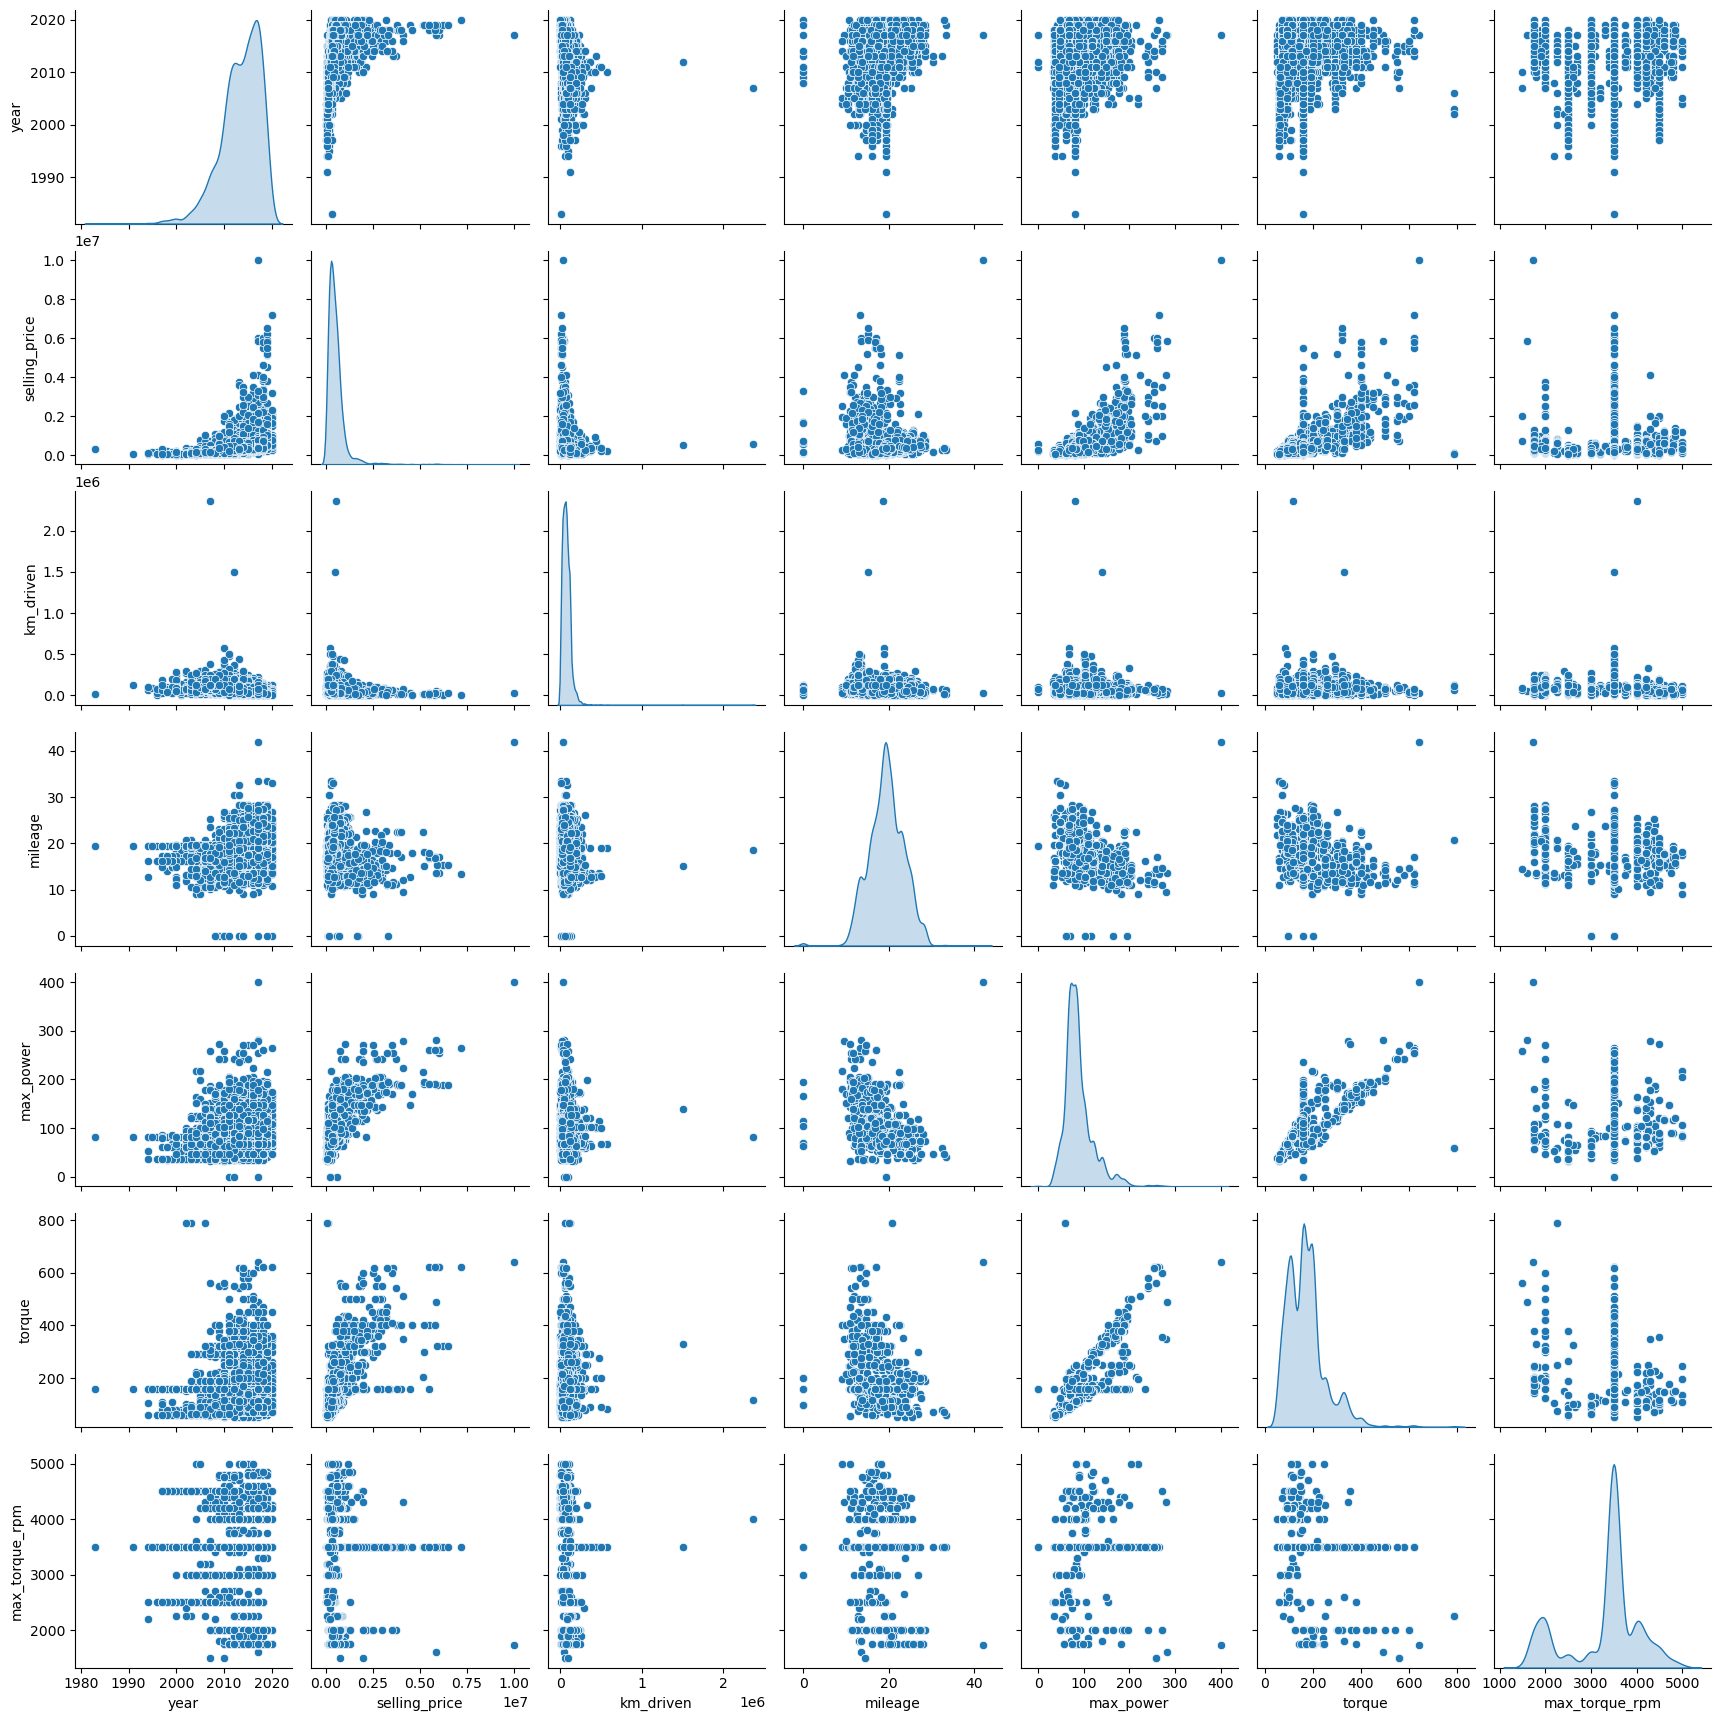

In [30]:
sns.pairplot(df_train[numeric_columns], diag_kind="kde")
plt.show()

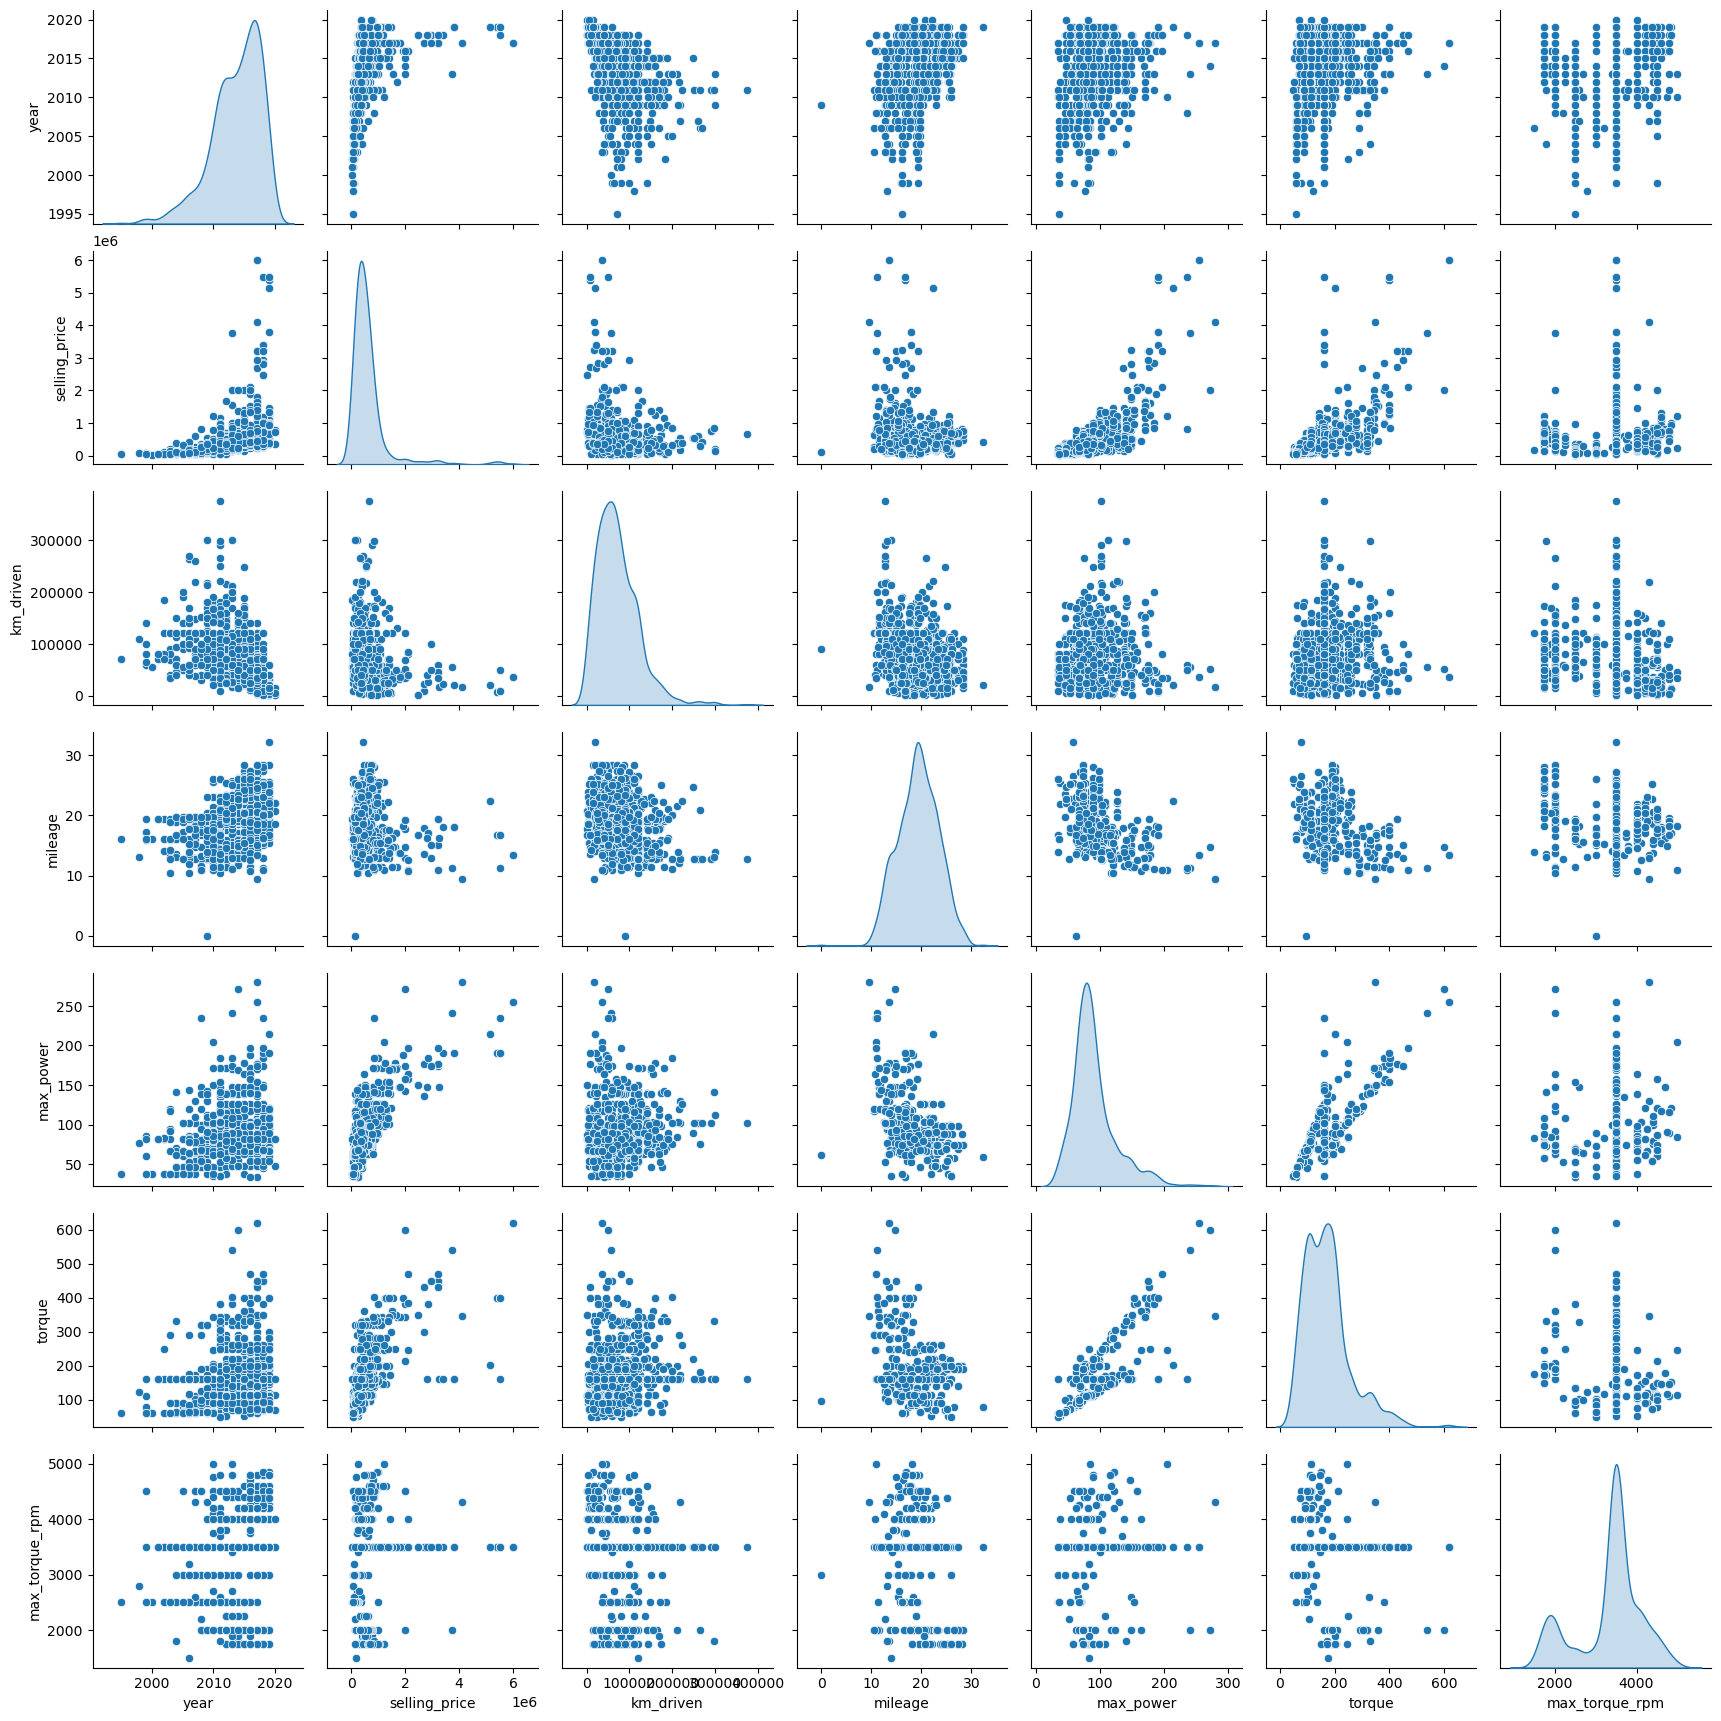

In [31]:
sns.pairplot(df_test[numeric_columns], diag_kind="kde")
plt.show()

# Шаг 1

- Да. Видна корреляция между selling_price и year, km_driven, mileage

- Да. Видны корреляции между:
 1) Негативная корреляция между mileage и max_power
 2) Позитивиная корреляция между max_power и torque
 3) Позитивная корреляция между km_driven и year

# Шаг 2

- Распределения в тестовых и тренировочных данных похожи

### **Задание 9 (0.5 балла)**

И так, вы выдвинули гипотезы о наличии связи. Теперь давайте оценим эту связь в числах.

**Задание:**
- [ ] Получите значения коэффициента корреляции Пирсона для тренировочного набора данных при помощи `pd.corr()`
- [ ] По полученным корреляциям постройте тепловую карту (`heatmap` из бибилотеки seaborn)

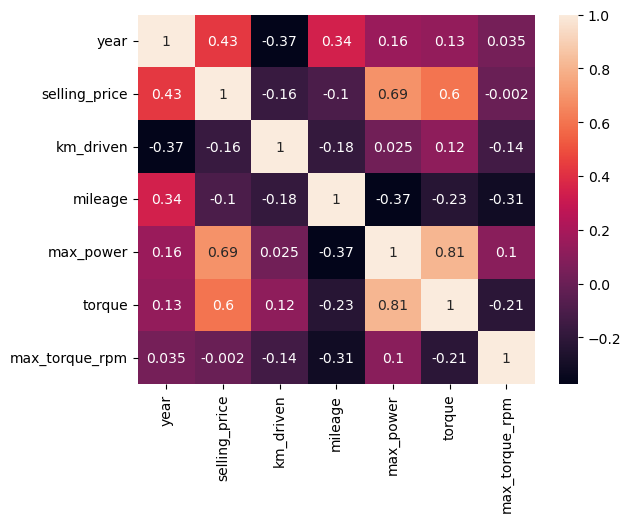

In [32]:
corr_matrix = df_train[numeric_columns].corr(method='pearson')

sns.heatmap(corr_matrix, annot=True)
plt.show()

- [ ] Ответьте на вопросы:
 - Какие 2 признака наименее скоррелированы между собой?
 - Между какими наблюдается довольно сильная положительная линейная зависимость?
 - Правильно ли, опираясь на данные, утверждать, что чем меньше год, тем, скорее всего, больше километров проехала машина к дате продажи?

- selling_price и max_torque_pm имеют наименьшую корреляцию
   
- torque и max_power имеют наибольшую корреляцию

- year и km_driven имеют отрицательную корреляцию => да, можно утверждать, что чем меньше год, тем, скорее всего, больше километров проехала машина к дате продажи

### **Задание 10 (0.6 балла)**

По умолчанию `pd.corr` возвращает корреляцию Пирсона, говорящую о линейной взаимосвязи. Но зависимости существуют не только линейные! В этой задаче, попробуйте измерить другие способы вычисления корреляций.

- [ ] Реализуйте корреляцию Спирмена/Кендала (на выбор) без использования библиотек (можно пользоваться только `numpy`). Сравните результаты вычисления с библиотечной реализацией
- [ ]

Постройте матрицу корреляции [phik](https://pypi.org/project/phik/)
- [ ] Проинтерпретируйте результаты


In [33]:
x = df_train['year'].values
y = df_train['selling_price'].values

rank_x = np.argsort(np.argsort(x))
rank_y = np.argsort(np.argsort(y))

covariance = np.sum((rank_x - rank_x.mean()) * (rank_y - rank_y.mean())) / len(x)
std_x = np.sqrt(np.sum((rank_x - rank_x.mean())**2) / len(x))
std_y = np.sqrt(np.sum((rank_y - rank_y.mean())**2) / len(x))

spearman_custom = covariance / (std_x * std_y)
spearman_lib, _ = spearmanr(x, y)

print(f"Сам посчитал: {spearman_custom:.4f}")
print(f"SciPy:: {spearman_lib:.4f}")

Сам посчитал: 0.7051
SciPy:: 0.7071


C:\Users\itsuki\anaconda3\Lib\site-packages\phik\data_quality.py:59: UserWarning: The number of unique values of variable name is large: 1924. Are you sure this is not an interval variable? Analysis for pairs of variables including name can be slow.
  warnings.warn(


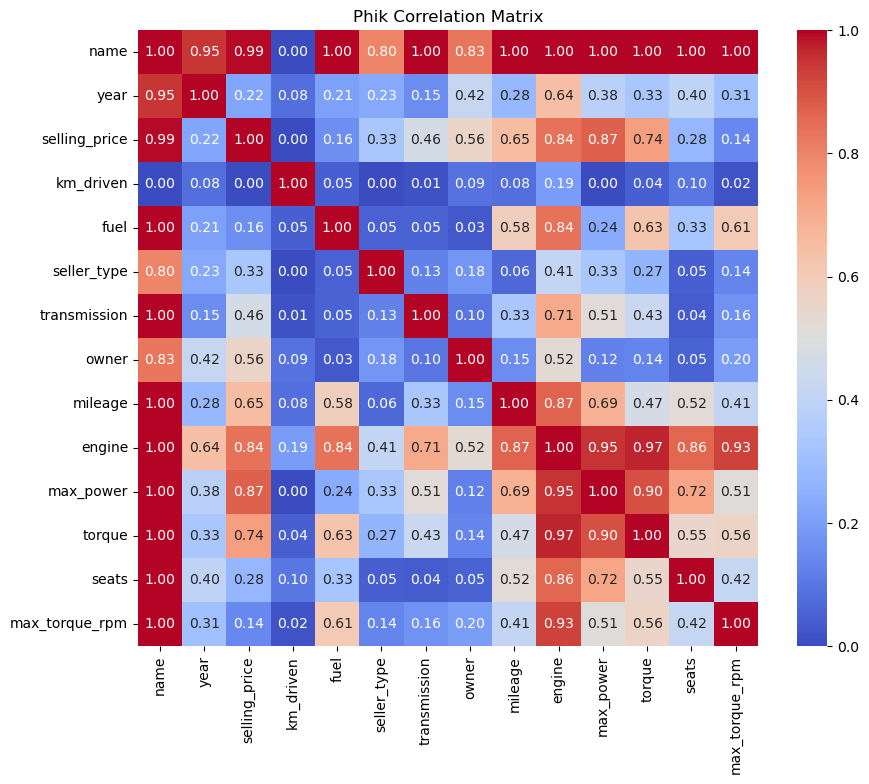

In [34]:
# Вычисляем корреляции Phik
phik_matrix = df_train.phik_matrix(interval_cols=numeric_columns)

# Визуализация тепловой карты
plt.figure(figsize=(10, 8))
sns.heatmap(phik_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Phik Correlation Matrix")
plt.show()

### **Дополнительные визуализации (бонус 0.2 балла)**

Если вам кажется, что мы не попросили вас нарисовать какие-то очень важные зависимости, нарисуйте их и поясните.

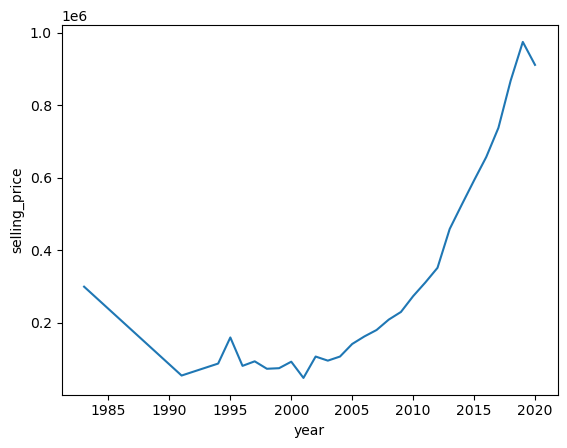

In [35]:
avg_price_by_year = df_train.groupby('year')['selling_price'].mean().reset_index()
sns.lineplot(x='year', y='selling_price', data=avg_price_by_year)
plt.show()

# **Часть 2 (1.7 балла) | Модель только на вещественных признаках**

В этой части вам предстоит обучить модель только на вещественных признаках. Почему только на них?

Чем больше признаковое пространство — чем сложнее модель. А чем модель проще — тем лучше для скорости работы и интерпретации признаков.

За задания этой части вы можете набрать 1.7 основных и 0.15 бонусных балла;

### **Задание 11 (0.05 балла)**

Разбейте данные на тренировочный и тестовый наборы. Перед разбиением создайте копию датафрейма, который будет хранить только вещественные признаки и используйте его (то есть категориальные столбцы (все, кроме seats) необходимо удалить).

В переменные y_train и y_test запишите значения целевых переменных.

In [36]:
df_num_train = df_train[['selling_price', 'seats', 'year', 'km_driven', 'mileage', 'engine', 'max_power', 'torque']]
df_num_test = df_test[['selling_price', 'seats', 'year', 'km_driven', 'mileage', 'engine', 'max_power', 'torque']]

In [37]:
X_train = df_num_train.drop(columns=['selling_price'])
y_train = df_num_train[['selling_price']]

X_test = df_num_test.drop(columns=['selling_price'])
y_test = df_num_test[['selling_price']]

In [38]:
assert X_train.shape == (5840, 7)

### **Задание 12. (0.2 балла)**

Построим нашу первую модель!
- [ ] Обучите классическую линейную регрессию с дефолтными параметрами. Посчтитайте $R^2$ и $MSE$ для трейна и для теста.
- [ ] Сделайте выводы по значениям метрик качества.

**Примечание:**

Здесь и далее $R^2$ и $MSE$ для трейна и для теста выводите везде, где требуется обучать модели, даже если в явном виде этого не просят. Иначе непонятно, как понять, насколько успешны наши эксперименты.

In [39]:
model = LinearRegression()

model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

r2_train = r2_score(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)

r2_test = r2_score(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print(f"Train:\nR^2 = {r2_train}, MSE = {mse_train}")
print(f"Test:\nR^2 = {r2_test}, MSE = {mse_test}")

Train:
R^2 = 0.5969180518634669, MSE = 115538739835.91565
Test:
R^2 = 0.5924362699020216, MSE = 234279270302.83774


### **Задание 13 (0.15 балла)**

- [ ] Реализуйте $R^2$ руками. Приведите формулу $R^2$ и объясните каждую компоненту метрики

In [40]:
r2 = 1 - (np.sum((y_test - y_test_pred) ** 2) / np.sum((y_test - np.mean(y_test_pred)) ** 2))
print(r2)

selling_price    0.59447
dtype: float64


C:\Users\itsuki\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


### **Бонус (0.15 балла)**

- [ ] Реализуйте [$\text{adjusted}-R^2$](https://en.wikipedia.org/wiki/Coefficient_of_determination).
- [ ] Объясните, когда применяется $\text{adjusted}-R^2$?

In [41]:
n = X_train.shape[0]
k = X_train.shape[1]

r2_train = r2_score(y_train, y_train_pred)

adjusted_r2_train = 1 - (1 - r2) * (n - 1) / (n - k - 1)

print(adjusted_r2_train)

selling_price    0.593983
dtype: float64


### **Задание 14 (0.05 балла)**

Всегда есть место совершенству. Поэтому давайте попробуем улучшить модель. При помощи стандартизации признаков.

- [ ] Стандартизируйте значения в тренировочных и тестовых данных. Стандартизатор **обучайте только на `train`**.

In [42]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LinearRegression()
model.fit(X_train_scaled, y_train)

y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

r2_train = r2_score(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)

r2_test = r2_score(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print(f"Train:\nR^2 = {r2_train:.4f}, MSE = {mse_train:.4f}")
print(f"Test:\nR^2 = {r2_test:.4f}, MSE = {mse_test:.4f}")

Train:
R^2 = 0.5969, MSE = 115538739835.9162
Test:
R^2 = 0.5924, MSE = 234279270302.8706


### **Задание 15 (0.1 балла)**

Хотя стандартизация не помогла сильно прибавить в качестве она открыла возможность интерпретировать важность признаков в модели. Правило интерпретации такое:

Чем больше коэффициент $\beta_i$ по модулю, тем важнее признак.

**Ответьте на вопрос:**

- [ ] Какой признак оказался наиболее информативным в предсказании цены?

In [43]:
coefficients = model.coef_.flatten()
feature_importance = dict(zip(X_train.columns, coefficients))

sorted_features = sorted(feature_importance.items(), key=lambda x: abs(x[1]), reverse=True)

most_informative_feature = sorted_features[0]
print(f"Наиболее информативный признак: {most_informative_feature[0]}")

Наиболее информативный признак: max_power


### **Задание 16 (0.25 балла)**

Попробуем улучшить нашу модель с помощью применения регуляризации. Для этого воспльзуемся `Lasso` регрессией.  Кроме того, попробуйте использовать её теоретическое свойство отбора признаков, за счет зануления незначимых коэффициентов.

**Задание:**

- [ ] Обучите Lasso регрессию на тренировочном наборе данных с нормализованными признаками. Оцените её качество
- [ ] Проверьте, занулила ли L1-регуляризация с параметрами по умолчанию какие-нибудь веса? Предположите почему.

In [44]:
lasso_model = Lasso()

lasso_model.fit(X_train_scaled, y_train)

y_train_pred = lasso_model.predict(X_train_scaled)
y_test_pred = lasso_model.predict(X_test_scaled)

r2_train = r2_score(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)

r2_test = r2_score(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print(f"Тренировочные данные:\nR^2 = {r2_train:.4f}, MSE = {mse_train:.4f}")
print(f"Тестовые данные:\nR^2 = {r2_test:.4f}, MSE = {mse_test:.4f}")

lasso_coefficients = lasso_model.coef_
print("\nКоэффициенты модели:")
for feature, coef in zip(X_train.columns, lasso_coefficients):
    print(f"{feature}: {coef:.4f}")

num_zero_coefficients = np.sum(lasso_coefficients == 0)
print(f"\nКоличество занулённых коэффициентов: {num_zero_coefficients}")

Тренировочные данные:
R^2 = 0.5969, MSE = 115538739845.3915
Тестовые данные:
R^2 = 0.5924, MSE = 234279974077.3235

Коэффициенты модели:
seats: -29684.0619
year: 157014.4643
km_driven: -46735.5228
mileage: 8578.0921
engine: 36160.2224
max_power: 274923.6475
torque: 72167.2289

Количество занулённых коэффициентов: 0


L1-регуляризация не привела к занулению коэффициентов, что может указывать на два возможных объяснения:
- Все признаки в данных могут быть достаточно информативными
- Коэффициент регуляризации недостаточно большой, чтобы занулить весаенных не дает регуляризации возможности эффективно занулять веса. Во-вторых, значение коэффициента регуляризации, выбранное по умолчанию, возможно, недостаточно велико, чтобы существенно повлиять на величины коэффициентов и привести к их занулению.

### **Задание 17. Финальный рывок (0.4 балла)**

До этого мы с вами использовали `train` для обучения и `test` для прогнозирования. Но у нас есть ещё одна задача — подобрать оптимальные параметры модели. Для этого используем кросс-валидацию, описанную на семинарах.

Кроме того, выжмем максимум из модификаций регрессии. Построим `ElasticNet`. И сделаем всё по порядку.

**Ваша задача 1:**

- [ ] Перебором по сетке (c 10-ю фолдами) подберите оптимальные параметры для Lasso-регрессии. Вам пригодится класс [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).
- [ ] Ответьте на вопросы:
 - Сколько грид-сёрчу пришлось обучать моделей?
 - Что значит каждый параметр `param_grid`, который вы заполняли для `GridSearch`? Опишите каждый
 - Какой коэффициент регуляризации у лучшей из перебранных моделей? Занулились ли какие-нибудь из весов при такой регуляризации?

In [45]:
param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100],
    'max_iter': [1000, 5000, 10000]         
}

lasso_model = Lasso()

grid_search = GridSearchCV(estimator=lasso_model, param_grid=param_grid, cv=10, scoring='r2', verbose=1)

grid_search.fit(X_train_scaled, y_train)

print(f"Лучшие параметры: {grid_search.best_params_}")
print(f"Лучший коэффициент регуляризации: {grid_search.best_params_['alpha']}")
print(f"Лучшее значение R^2 на валидации: {grid_search.best_score_:.4f}")

best_lasso_model = grid_search.best_estimator_

best_lasso_coefficients = best_lasso_model.coef_
num_zero_coefficients = (best_lasso_coefficients == 0).sum()

Fitting 10 folds for each of 18 candidates, totalling 180 fits
Лучшие параметры: {'alpha': 100, 'max_iter': 1000}
Лучший коэффициент регуляризации: 100
Лучшее значение R^2 на валидации: 0.5731


In [46]:
num_zero_coefficients = (best_lasso_coefficients == 0).sum()
print(f"Количество занулённых коэффициентов: {num_zero_coefficients}")

Количество занулённых коэффициентов: 0


**Ваша задача 2:**

- [ ] Перебором по сетке (c 10-ю фолдами) подберите оптимальные параметры для [ElasticNet](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html) регрессии.
- [ ] Ответьте на вопрос:
 - Сколько грид-сёрчу пришлось обучать моделей?
 - Какие гиперпараметры соответствуют лучшей (по выбранной метрике качества) из перебранных моделей?

In [47]:
param_grid_elasticnet = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100],
    'l1_ratio': [0.1, 0.5, 0.7, 0.9],   
    'max_iter': [1000, 5000]      
}

elasticnet_model = ElasticNet()

grid_search_elasticnet = GridSearchCV(
    estimator=elasticnet_model,
    param_grid=param_grid_elasticnet,
    cv=10,
    scoring='r2',
    verbose=1
)

grid_search_elasticnet.fit(X_train_scaled, y_train)

print(f"Лучшие параметры: {grid_search_elasticnet.best_params_}")
print(f"Лучший коэффициент регуляризации (alpha): {grid_search_elasticnet.best_params_['alpha']}")
print(f"Лучшее значение L1-ratio: {grid_search_elasticnet.best_params_['l1_ratio']}")
print(f"Лучшее значение R^2 на валидации: {grid_search_elasticnet.best_score_:.4f}")


num_models_trained = len(param_grid_elasticnet['alpha']) * len(param_grid_elasticnet['l1_ratio']) * len(param_grid_elasticnet['max_iter']) * 10
print(f"\nКоличество моделей, обученных GridSearchCV: {num_models_trained}")

Fitting 10 folds for each of 48 candidates, totalling 480 fits
Лучшие параметры: {'alpha': 1, 'l1_ratio': 0.9, 'max_iter': 1000}
Лучший коэффициент регуляризации (alpha): 1
Лучшее значение L1-ratio: 0.9
Лучшее значение R^2 на валидации: 0.5802

Количество моделей, обученных GridSearchCV: 480


### **Задание 18 (0.35 балла)**

И так, вы обучили все варианты регуляризаций, доступные в sklearn, но не все, что мы обсудили на занятии! И следующее задание о забытой - $L0$ регуляризации.


**Ваша задача:**>
- [ ] Реализуйте модель с $L0$-регуляризаицей.
- [ ] Обучите модель на данных и проанализируйте результат, экспериментируя с коэффициенитом регуляризации
- [ ] Проанализируйте результаты обучения

**Важно:**

Вопреки тому, что L0 не реализована в стандартных пакетах, концепция данной регуляризации не является мертвой. Она может встречаться в [статьях](https://arxiv.org/abs/1712.01312) и экспериментах.



In [48]:
num_features = 7
n_targets = 1

# 2. Функция для расчета AIC и BIC для многомерной регрессии
def calculate_aic_bic_multi(model, X, Y):
    n, k = X.shape[0], X.shape[1]  # Число наблюдений и признаков
    n_targets = Y.shape[1]  # Число целевых переменных
    y_pred = model.predict(X)
    residual_sum_of_squares = np.sum((Y - y_pred) ** 2)

    # Средняя ошибка для всех компонент целевой переменной
    mse = mean_squared_error(Y, y_pred, multioutput='uniform_average')
    log_likelihood = -n * n_targets / 2 * (np.log(2 * np.pi * mse) + 1)

    # Количество параметров = (число признаков + 1) * число целевых переменных
    total_params = n_targets * (k + 1)

    aic = 2 * total_params - 2 * log_likelihood
    bic = total_params * log(n) - 2 * log_likelihood

    return aic, bic

# 3. Перебор комбинаций признаков для минимизации AIC/BIC
min_aic, min_bic = float('inf'), float('inf')
best_aic_model, best_bic_model = None, None

for num_features in range(1, num_features + 1):
    for feature_subset in combinations(X_train.columns[:num_features], num_features):
        # Подготовка данных
        X_subset = X_train[list(feature_subset)].values
        Y_subset = y_train[[f"selling_price" for i in range(n_targets)]].values

        # Обучение модели
        model = LinearRegression()
        model.fit(X_subset, Y_subset)

        # Расчет AIC и BIC
        aic, bic = calculate_aic_bic_multi(model, X_subset, Y_subset)

        # Обновление лучших моделей
        if aic < min_aic:
            min_aic = aic
            best_aic_model = (model, feature_subset)

        if bic < min_bic:
            min_bic = bic
            best_bic_model = (model, feature_subset)

# 4. Вывод результатов
print(f"Best AIC: {min_aic:.2f} using features {best_aic_model[1]}")
print(f"Best BIC: {min_bic:.2f} using features {best_bic_model[1]}")

# 5. Оценка на тестовой выборке
X_test_np = X_test.values

# Access columns by index using NumPy-style slicing
X_test_aic = X_test[list(best_aic_model[1])].values
X_test_bic = X_test[list(best_bic_model[1])].values

# Evaluate the selected models on the test set
aic_test_mse = mean_squared_error(y_test, best_aic_model[0].predict(X_test_aic), multioutput='uniform_average')
bic_test_mse = mean_squared_error(y_test, best_bic_model[0].predict(X_test_bic), multioutput='uniform_average')

print(f"Test MSE for AIC-selected model: {aic_test_mse:.4f}")
print(f"Test MSE for BIC-selected model: {bic_test_mse:.4f}")

print(r2_score(y_test, best_aic_model[0].predict(X_test_aic)))
print(r2_score(y_test, best_bic_model[0].predict(X_test_bic)))

Best AIC: 165350.77 using features ('seats', 'year', 'km_driven', 'mileage', 'engine', 'max_power', 'torque')
Best BIC: 165404.15 using features ('seats', 'year', 'km_driven', 'mileage', 'engine', 'max_power', 'torque')
Test MSE for AIC-selected model: 234279270302.8377
Test MSE for BIC-selected model: 234279270302.8377
0.5924362699020216
0.5924362699020216


# **Часть 3 (0.5 балла) | Добавляем категориальные фичи**

Попробуем для улучшения модели дать ей больше признаков. Добавим категориальные фичи.

За эту часть можно набрать 0.5 основных балла.



### **Задание 19 (0.1 балла)**

Проанализируйте столбец `name`. Очевидно, что эта переменная является категориальной, однако категорий в ней много.

- [ ] Предобработайте столбец `name`, чтобы избежать его удаления

In [49]:
df_train_cat = df_train.copy()
df_test_cat = df_test.copy()

df_train_cat['manufacturer'] = df_train_cat['name'].apply(lambda x: x.split()[0])
df_train_cat['model'] = df_train_cat['name'].apply(lambda x: x.split()[1] if len(x.split()) > 1 else 'Unknown')

df_test_cat['manufacturer'] = df_test_cat['name'].apply(lambda x: x.split()[0])
df_test_cat['model'] = df_test_cat['name'].apply(lambda x: x.split()[1] if len(x.split()) > 1 else 'Unknown')

threshold = 20

common_models = df_train_cat['model'].value_counts()
common_models = common_models[common_models > threshold].index

df_train_cat['model_grouped'] = df_train_cat['model'].apply(lambda x: x if x in common_models else 'Other')
df_test_cat['model_grouped'] = df_test_cat['model'].apply(lambda x: x if x in common_models else 'Other')

df_train_cat = df_train_cat.drop(columns=['name', 'model'])
df_test_cat = df_test_cat.drop(columns=['name', 'model'])

y_train_cat = df_train_cat[['selling_price']]
X_train_cat = df_train_cat.drop(columns=['selling_price'])

y_test_cat = df_test_cat[['selling_price']]
X_test_cat = df_test_cat.drop(columns=['selling_price'])

In [50]:
assert X_train_cat.shape == (5840, 14)

In [51]:
X_train_cat.describe(include='object')

fuel seller_type transmission        owner manufacturer  \
count     5840        5840         5840         5840         5840   
unique       4           3            2            5           30   
top     Diesel  Individual       Manual  First Owner       Maruti   
freq      3177        5223         5336         3603         1804   

       model_grouped  
count           5840  
unique            62  
top            Other  
freq             841

### **Задание 20 (0.1 балла)**

- [ ] Закодируйте категориалльные фичи и ``seats`` методом OneHot-кодирования.

In [52]:
columns_to_encode = ['transmission', 'seller_type', 'fuel', 'owner', 'seats', 'transmission', 'manufacturer', 'model_grouped']

missing_columns = [col for col in columns_to_encode if col not in X_train_cat.columns]

X_train_cat_encoded = pd.get_dummies(X_train_cat, columns=columns_to_encode, drop_first=False)
X_test_cat_encoded = pd.get_dummies(X_test_cat, columns=columns_to_encode, drop_first=False)

X_train_cat_encoded, X_test_cat_encoded = X_train_cat_encoded.align(X_test_cat_encoded, join='outer', axis=1, fill_value=0)

print(f"Train set shape: {X_train_cat_encoded.shape}")
print(f"Test set shape: {X_test_cat_encoded.shape}")

Train set shape: (5840, 130)
Test set shape: (1000, 130)


### **Задание 21 (0.2 балла)**

OHE — базовый алгоритм преобразования категориальных признаков, но и с ним нужно быть аккуратными.

**Ответьте на вопросы:**


* Как корректно работать с OHE преобразованием?
* Почему мы удаляем один столбец?
* Пусть из $n$ признаков мы получили $n-1$ столбец, из которых $k < n -1$ оказались не важными по весам модели. Корректно ли их удалить?

- Использовать drop_first=True, чтобы избежать мультиколлинеарности.  
- Это нужно для предотвращения мультиколлинеарности, когда один из столбцов можно выразить через другие. Такая зависимость может негативно повлиять на модели, которые чувствительны к взаимной корреляции признаков.
- Да, если признаки не влияют существенно на модель, их удаление может уменьшить размерность данных и ускорить обучение без значительного снижения качества работы модели.

### **Задание 22 (0.1 балла)**
Повторим то, что делали на прошлом шаге для моделей на вещественных признаках, однако теперь с моделью `Ridge`.


**Ваша задача:**
- [ ] Переберите параметр регуляризации `alpha` для гребневой (ridge) регрессии с помощью класса `GridSearchCV` В качестве параметров при объявлении GridSearchCV кроме модели укажите метрику качества $R^2$. Кроссвалидируйтесь по 10-ти фолдам.
- [ ] Ответье на вопрос: Удалось ли улучшить качество прогнозов?

In [53]:
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

ridge = Ridge()

grid_search = GridSearchCV(
    estimator=ridge,
    param_grid=param_grid,
    scoring=make_scorer(mean_squared_error, greater_is_better=False),
    cv=10
)

grid_search.fit(X_train_cat_encoded, y_train_cat.values.ravel())

best_alpha = grid_search.best_params_['alpha']
best_score = -grid_search.best_score_

final_model = Ridge(alpha=best_alpha)
final_model.fit(X_train_cat_encoded, y_train_cat)

test_predictions = final_model.predict(X_test_cat_encoded)
test_mse = mean_squared_error(y_test_cat, test_predictions)
test_r2 = r2_score(y_test_cat, test_predictions)

print(f"Лучший alpha: {best_alpha}")
print(f"Лучший MSE на кросс-валидации: {best_score}")
print(f"MSE на тесте: {test_mse}")
print(f"R2 на тесте: {test_r2}")

C:\Users\itsuki\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=5.0048e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\itsuki\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=5.00723e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\itsuki\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=5.58211e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\itsuki\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=5.04282e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\itsuki\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.p

Лучший alpha: 0.001
Лучший MSE на кросс-валидации: 73284939528.22917
MSE на тесте: 112655649774.29973
R2 на тесте: 0.8040186962368692


C:\Users\itsuki\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=4.72694e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\itsuki\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=4.72694e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


# **Часть 4 - бонусная (1 балл) | Feature Engineering**

В этой части домашнего задания вам предлагается проявить свою креативность для улучшения прогноза модели. Любые другие модели, кроме различных форм линейной (или полиномиальной) регресси, использовать запрещается. А значит, придется работать с признаками

**Что можно попробовать сделать?** (каждый пункт по 0.4 балла, но не больше 2-х баллов в сумме)

1.   *Сгенерировать новые признаки на основе уже существующих:*
    * посчитать произведения // частные признаков (кажется, что посчитать число "лошадей" на литр объема может быть полезно);
    * имеет смысл обратить внимание на визуализации в части с EDA (к примеру, зависимость цены от года выглядит квадратичной, а не линейной; значит, квадрат года нам, скорее всего, принесет больше пользы)

2.   *Добыть новые признаки:*
    * имеем название автомобиля, которое никак не используем (можно спарсить инфу о классе автомобиля или каких-то специфических опциях)
    * можно добавить пороговые признаки вроде "владелец третий или больше" и объединить признаки в некоторые осмысленные правила, например "первый или второй владелец и продавец официальный дилер" (подбирать пороги удобно по диаграммам рассеяния)

3.   *Поработать с уже имеющимися:*
    * далеко не факт, что заполнить пропуск медианой было лучшей идеей (как минимум, можно добавить dummy-столбец для модели, сигнализирующий, что раньше на месте медианы был пропуск -- там где он был, конечно); попробуйте другие способы филлинга;
    * мы не анализировали, есть ли в данных выбросы => никак выбросы не обрабатывали; наиболее простым и, тем не менее, довольно полезным вариантом нахождения выбросов могут послужить boxplot'ы для каждого столбца; что делать с выбросами думайте сами :) -- вариантов довольно много
    * мы толком не смотрели на таргет сам по себе; в нем тоже могут быть неожиданности -- стоит хотя бы проверить
    * можно заметить, что некоторые признаки распределены совсем не нормально; возможно их стоит отлогарифмировать

И так далее...

Feel Free to Try!

In [54]:
def generate_features(df):
    df.loc[:, 'power_per_liter'] = df['max_power'] / df['engine']
    df.loc[:, 'year_squared'] = (2024 - df['year']) ** 2 
    df.loc[:, 'age_per_km'] = (2024 - df['year']) / df['km_driven'] 

    df.loc[:, 'is_big_engine'] = df['engine'] > 2000 
    df.loc[:, 'is_low_power'] = df['max_power'] < 100

generate_features(X_train_cat_encoded)
generate_features(X_test_cat_encoded)

In [55]:
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

ridge = Ridge()

grid_search = GridSearchCV(
    estimator=ridge,
    param_grid=param_grid,
    scoring=make_scorer(mean_squared_error, greater_is_better=False),
    cv=10
)

grid_search.fit(X_train_cat_encoded, y_train_cat.values.ravel())

best_alpha = grid_search.best_params_['alpha']

final_model = Ridge(alpha=best_alpha)
final_model.fit(X_train_cat_encoded, y_train_cat)

y_pred = final_model.predict(X_test_cat_encoded)

C:\Users\itsuki\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=5.00089e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\itsuki\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=5.00263e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\itsuki\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=5.57638e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\itsuki\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=5.03811e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\itsuki\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.

# **Часть 4. | Бизнесовая (0.5 балла)**

### **Задание 23 (0.25 балла)**

В мире бизнеса очень важно давать оценку качества модели понятную бизнесу, поэтому иногда заказчики приходят с кастомными метриками. Попробуем сделать такую для нашей задачи.

**Описание метрики:**

Среди всех предсказанных цен на авто нужно посчитать долю прогнозов, отличающихся от реальных цен на эти авто не более чем на 10% (в одну или другую сторону)

**Ваша задача:**

- [ ] Реализуйте метрику `business_metric`
- [ ] Посчитайте метрику для всех обученных моделей и определеите, какаю лучше всего решает задачу бизнеса

In [56]:
def business_metrics(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    relative_error = np.abs(y_pred - y_true) / y_true
    return np.mean(relative_error <= 0.1)

business_metrics(y_test_cat, y_pred)

0.317

### **Задание 24 (0.25 балла)**

Но у бизнеса не всегда есть идеи и иногда задача на выбор метрики делегируется вам.

**Задание:**

- [ ] Придумайте и реализуйте другую кастомную метрику с учетом того, что модель не должна сильно ошибаться в прогнозе, но недопрогноз для модели, согласно мнению бизнеса, хуже, чем перепрогноз.
- [ ] Посчитайте метрику для всех обученных моделей и определеите, какаю лучше всего решает задачу бизнеса



In [57]:
def custom_business_metric(y_true, y_pred, alpha=2):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    underforecast = y_pred < y_true
    overforecast = y_pred >= y_true
    
    errors = np.abs(y_pred - y_true)
    
    weighted_errors = np.where(underforecast, errors * alpha, errors)
    
    return np.mean(weighted_errors)

business_metrics(y_test_cat, y_pred)

0.317

# **Часть 5 (3 балла) | Реализация сервиса на FastAPI**

### **Задание 25**

Cделайте с помощью FastAPI сервис, который с точки зрения пользователя реализует две функции:

1. на вход в формате json подаются признаки одного объекта, на выходе сервис выдает предсказанную стоимость машины
2. на вход подается csv-файл с признаками тестовых объектов, на выходе получаем файл с +1 столбцом - предсказаниями на этих объектах

С точки зрения реализации это означает следующее:
- средствами pydantic должен быть описан класс базового объекта
- класс с коллецией объектов
- метод post, который получает на вход один объект описанного класса
- метод post, который получает на вход коллекцию объектов описанного класса

Шаблон для сервисной части дан ниже. Код необходимо дополнить и оформить в виде отдельного .py-файла.

In [66]:
data

year  km_driven  power_per_liter  mileage  torque
0     2014     145500         0.059295    23.40   190.0
1     2014     120000         0.069105    21.14   250.0
2     2010     127000         0.064470    23.00   160.0
3     2007     120000         0.067951    16.10   160.0
4     2017      45000         0.068388    20.14   160.0
...    ...        ...              ...      ...     ...
5835  2008     191000         0.057182    17.92    96.1
5836  2013      50000         0.067234    18.90    90.0
5837  2013     110000         0.069215    18.50   113.7
5838  2007     119000         0.073677    16.80   160.0
5839  2009     120000         0.059215    19.30   190.0

[5840 rows x 5 columns]

In [67]:
y_train_cat

selling_price
0            450000
1            370000
2            225000
3            130000
4            440000
...             ...
5835         120000
5836         260000
5837         320000
5838         135000
5839         382000

[5840 rows x 1 columns]

In [69]:
data = X_train_cat_encoded[["year", "km_driven", "power_per_liter", "mileage", "torque"]]

ss = StandardScaler()
ss.fit(data)

grid_search.fit(data, y_train_cat.values.ravel())

best_alpha = grid_search.best_params_['alpha']

final_model = Ridge(alpha=best_alpha)
final_model.fit(data, y_train_cat)

with open('model.pkl','wb') as f:
    pickle.dump(final_model,f)

with open("scaler.pkl", "wb") as f:
    pickle.dump(ss, f)

data.to_csv("data.csv", index=False)

In [59]:
from fastapi import FastAPI
from pydantic import BaseModel
from typing import List

app = FastAPI()


class Item(BaseModel):
    name: str
    year: int
    selling_price: int
    km_driven: int
    fuel: str
    seller_type: str
    transmission: str
    owner: str
    mileage: str
    engine: str
    max_power: str
    torque: str
    seats: float


class Items(BaseModel):
    objects: List[Item]


@app.post("/predict_item")
def predict_item(item: Item) -> float:
    return ...


@app.post("/predict_items")
def predict_items(items: List[Item]) -> List[float]:
    return ...

Протестируйте сервис на корректность работы и приложите скриншоты (см. ниже).

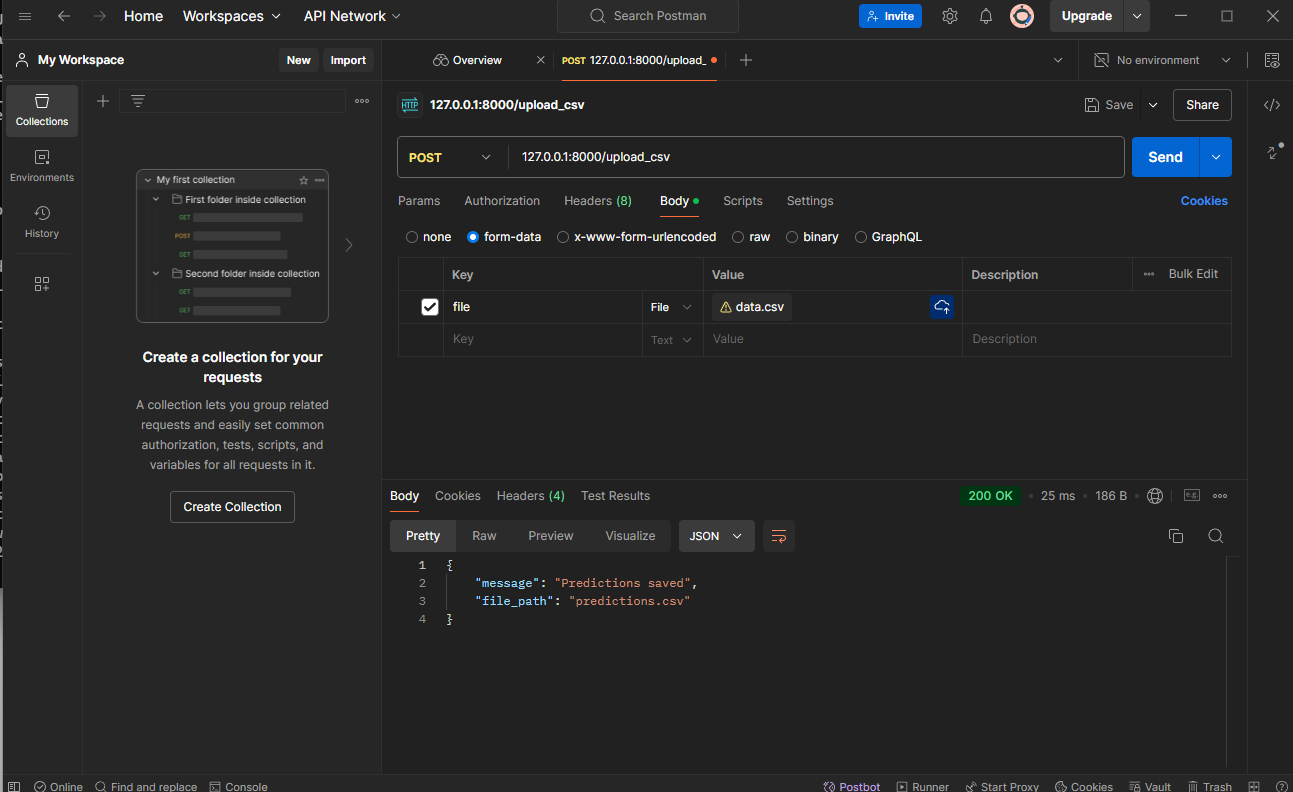

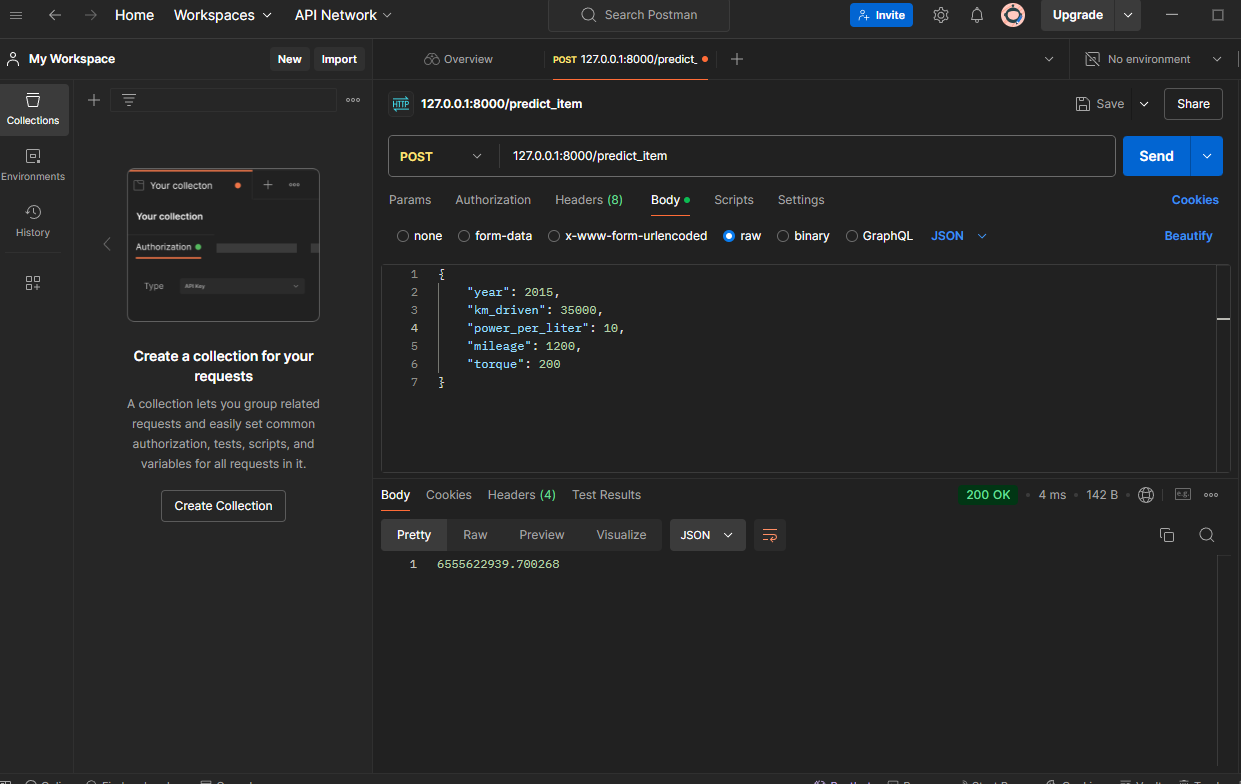

# **Часть 6 (1 балл) | Оформление результатов**

### **Задание 26**

**Результаты вашей работы** необходимо разместить в своем Гитхабе. Под результатами понимаем следующее:
* ``.ipynb``-ноутбук со всеми проведёнными вами экспериментами (output'ы ячеек, разумеется, сохранить)
* ``.py``-файл с реализацией сервиса
* ``.pickle``-файл с сохранёнными весами модели, коэффициентами скейлинга и прочими числовыми значениями, которые могут понадобиться для инференса
* ``.md``-файл с выводами про проделанной вами работе:
    * что было сделано
    * с какими результатами
    * что дало наибольший буст в качестве
    * что сделать не вышло и почему (это нормально, даже хорошо😀)

**За что могут быть сняты баллы в этом пункте:**
* за отсутствие ``.pickle``-файла с весами использованной модели
* за недостаточную аналитику в ``.md``-файле
* за оформление и логику кода (в определённом смысле это тоже элемент оформления решения)

**Как будет выглядет проверка всего домашнего задания?**
1. Ассистент проходит по ссылке на (**открытый**) репозиторий из Энитаска
2. Смотрит ``readme.md``:
    * пожалуйста, приложите в него же скрины работы вашего сервиса -- собирать ваши проекты довольно времязатратно, но хочется убедиться, что всё работает
    * можете в md-файл приложить ссылку на screencast с демонстрацией

3. Просматривает ноутбук с DS частью
4. Заглядывает в код сервиса
5. Хвалит

# **Часть Благодарственная**

Надеемся, вы честно проделали все пункты, а не просто пролистали досюда. Потому что здесь награда за старания. Пожалуйста, не стоит награждать себя до того, как закончите работать над домашкой.

<details>
<summary><b>Что-то приятное</b></summary>

**Напоминаем, что нашем курсе действует система кото-бонусов** 🐈

На фото по ссылке — сэр кот кого-то из команды курса (преподаватель, помощник преподавателя, ассистенты).

Предлагаем вам угадать — чей это товарищ!

[Первый кот](https://ibb.co/Kz1ZRWj)

</details>